<a href="https://colab.research.google.com/github/Nov05/DS-Unit-2-Sprint-4-Project/blob/master/notebooks/01_data_exploratory_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# created by nov05 on 2019-07-29
# DS-Unit-2-Sprint-4-Project/
# notebooks/

# Imports

In [0]:
# !pip install --upgrade pandas-profiling
# !pip install category_encoders
# !pip install eli5 pdpbox shap

In [0]:
from google.colab import widgets, files

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import datetime as dt
from itertools import chain
from random import randint
import shap

import sklearn
from sklearn import datasets

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, \
     ExtraTreesClassifier, ExtraTreesRegressor, \
     GradientBoostingClassifier, GradientBoostingRegressor, \
     RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, \
     GridSearchCV, cross_val_score, validation_curve, \
     RandomizedSearchCV
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.svm import SVC, LinearSVC, NuSVC

from sklearn.metrics import mean_absolute_error, \
     mean_squared_error, mean_squared_log_error, \
     accuracy_score, log_loss, r2_score, \
     classification_report, confusion_matrix, \
     roc_auc_score
from sklearn.utils.multiclass import unique_labels

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, \
     OneHotEncoder, OrdinalEncoder, LabelEncoder

import category_encoders as ce
from category_encoders.binary import BinaryEncoder 

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

import eli5
from eli5.sklearn import PermutationImportance

from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')   

In [0]:
!python --version
print("pandas_profiling", pandas_profiling.__version__)  
print("category_encoders", ce.__version__)  
print("pandas", pd.__version__)  
print("sklearn", sklearn.__version__)  
print("SHAP", shap.__version__)

Python 3.6.8
pandas_profiling 2.3.0
category_encoders 2.0.0
pandas 0.24.2
sklearn 0.21.2
SHAP 0.29.3


In [0]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
  
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Data profiling  

Data source https://github.com/Derek-Jones/SiP_dataset

In [0]:
url_tasks = "https://raw.githubusercontent.com/Derek-Jones/SiP_dataset/master/Sip-task-info.csv"
url_dates = "https://raw.githubusercontent.com/Derek-Jones/SiP_dataset/master/est-act-dates.csv"

In [0]:
tasks  = pd.read_csv(url_tasks, encoding='iso-8859-1')
print(tasks.shape)
tasks.head(3)

(12299, 17)


TaskNumber  ... DeveloperPerformance
0        1735  ...                12.25
1        1742  ...                 0.00
2        1971  ...                 0.00

[3 rows x 17 columns]

In [0]:
dates  = pd.read_csv(url_dates, encoding='iso-8859-1')
print(dates.shape)
dates.head()

(12299, 4)


TaskNumber EstimateOn  StartedOn CompletedOn
0        2610  02-Nov-04  02-Nov-04   16-Nov-04
1        2617  05-Nov-04  05-Nov-04   30-Nov-04
2        2618  09-Nov-04  09-Nov-04   06-Jan-05
3        2620  09-Nov-04  09-Nov-04   27-Jan-05
4        2623  10-Nov-04  10-Nov-04   15-Aug-05

In [402]:
tasks.profile_report()

In [403]:
dates.profile_report()

# Data exploratory analysis

### Actual hours

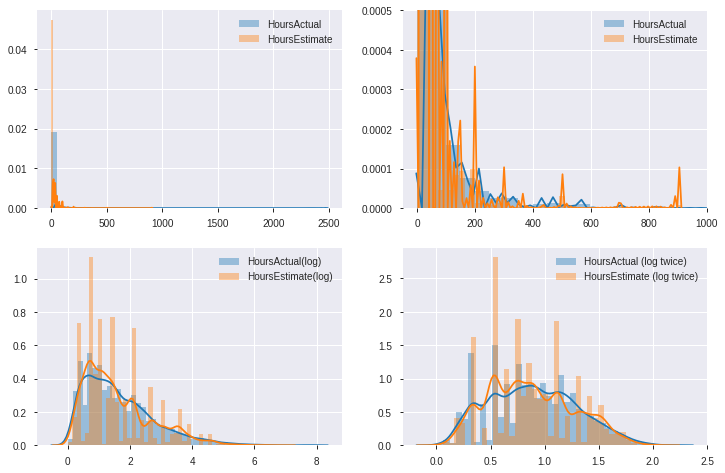

In [0]:
# target value distribution
y = tasks['HoursActual'].to_list()
y_log = np.log1p(y)
y_log2 = np.log1p(y_log)

x = tasks['HoursEstimate'].to_list()
x_log = np.log1p(x)
x_log2 = np.log1p(x_log)

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
sns.distplot(y, label='HoursActual')
sns.distplot(x, label='HoursEstimate')
plt.legend()

# zoom in target feature distribution
# it has a very long tail
plt.subplot(2,2,2)
sns.distplot(y, label='HoursActual')
sns.distplot(x, label='HoursEstimate')
plt.xlim(-50,1000)
plt.ylim(0,0.0005)
plt.legend()

# log 
plt.subplot(2,2,3)
sns.distplot(y_log, label='HoursActual(log)')
sns.distplot(x_log, label='HoursEstimate(log)')
plt.legend()

# log twice
plt.subplot(2,2,4)
sns.distplot(y_log2, label='HoursActual (log twice)')
sns.distplot(x_log2, label='HoursEstimate (log twice)')
plt.legend();

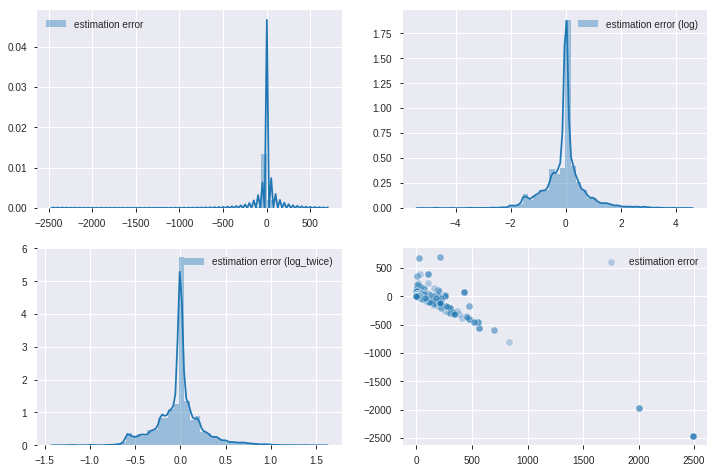

In [0]:
plt.figure(figsize=(12,8))

# estimation error
plt.subplot(221)
sns.distplot(np.array(x)-np.array(y), 
             label='estimation error')
plt.legend()

# estimation error (log)
plt.subplot(222)
sns.distplot(np.array(x_log)-np.array(y_log), 
             label='estimation error (log)')
plt.legend()

# estimation error (log twice)
plt.subplot(223)
sns.distplot(np.array(x_log2)-np.array(y_log2), 
             label='estimation error (log_twice)')
plt.legend()

plt.subplot(224)
sns.scatterplot(y, np.array(x)-np.array(y),
                label='estimation error',
                alpha=0.3)
plt.legend();

### Assigned To ID

Number of developers: 23


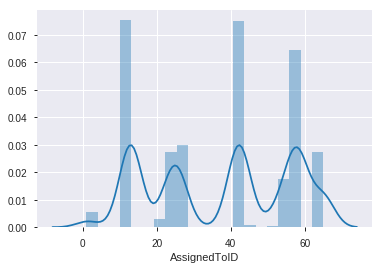

In [0]:
# it is highly imbalanced for different developers.
print("Number of developers:", len(tasks['AssignedToID'].unique()))
sns.distplot(tasks['AssignedToID']);

### Project Code & Breakdown Code

In [0]:
# there are projects very different in size
# could use the project task number as a feature
# domain knowledge: the more tasks a project has, the more complex it is
tasks['ProjectCode'].value_counts()

PC2     4553
PC18    2888
PC9     1755
PC5      648
PC4      511
PC17     449
PC11     292
PC6      287
PC13     171
PC7      145
PC16     114
PC14     105
PC3       87
PC10      73
PC8       64
PC12      54
PC1       54
PC19      41
PC20       5
PC15       3
Name: ProjectCode, dtype: int64

In [0]:
# could use number of differnt ProjectBreakdownCode as a feature
print('ProjectBreakdownCode:', len(tasks['ProjectBreakdownCode'].value_counts()))
tasks[['ProjectCode', 'ProjectBreakdownCode']].groupby('ProjectCode').nunique().head()

ProjectBreakdownCode: 77


ProjectCode  ProjectBreakdownCode
ProjectCode                                   
PC1                    1                     1
PC10                   1                     2
PC11                   1                     8
PC12                   1                     1
PC13                   1                     3

### Summary

In [0]:
# could analysis word frequency for different tasks, actual hours, etc.
for s in tasks['Summary'].sample(10).to_list():
  print(s)

YYY ZZZ cannot undelete a Risk
Create New Source Safe Repository For SiP Lloyd's Version 3.
Releasing the DEMO systemo to LIVE
Set Up Score Card For Staff Reviews
SCMS Progress Catch-up
XXXX Live Database Corrupt USM Transaction Narrative Page File Fix
Warehouse Conversion Helper Script
Release Technical Core 1.6.2140.20887
CCC - Request to upgrade valaidation error type from Info to Warning
LinkEX install at YYY ZZZ Uni - supporting issue with SQL Server SP2 


### Dates

(91, 4)


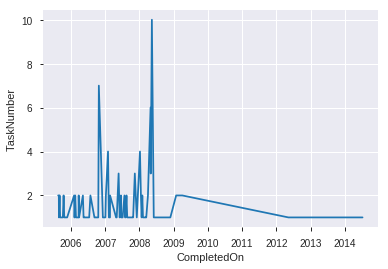

In [0]:
# tasks with CompletedOn but StartedOn missing
no_startedon = dates[(dates['StartedOn'].isna()==True) & (dates['CompletedOn'].isna()==False)]
no_startedon['CompletedOn'] = pd.to_datetime(no_startedon['CompletedOn'], format='%d-%b-%y')
no_startedon = no_startedon.groupby('CompletedOn').count().reset_index()
sns.lineplot(x='CompletedOn', y="TaskNumber",
             data=no_startedon);
print(no_startedon.shape)


(1169, 4)


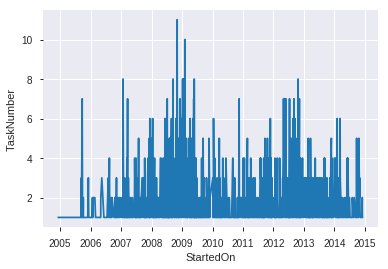

In [0]:
# tasks with StartedOn but CompletedOn missing
no_completedon = dates[(dates['StartedOn'].isna()==False) & (dates['CompletedOn'].isna()==True)]
no_completedon['StartedOn'] = pd.to_datetime(no_completedon['StartedOn'], format='%d-%b-%y')
no_completedon = no_completedon.groupby('StartedOn').count().reset_index()
sns.lineplot(x='StartedOn', y="TaskNumber",
             data=no_completedon);
print(no_completedon.shape)

8088


TaskNumber  EstimateOn  StartedOn  CompletedOn
0        1735           1          1            1
1        1742           1          1            1
2        1971           1          1            1
3        2134           1          1            1
4        2251           1          1            1

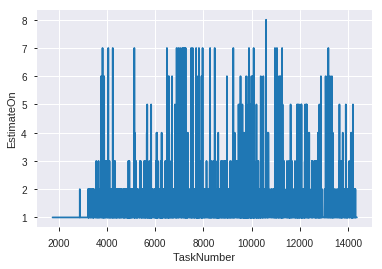

In [0]:
# tasts with both dates missing
# tasks with StartedOn but CompletedOn missing
no_dates = dates[(dates['StartedOn'].isna()==False) & (dates['CompletedOn'].isna()==False)]
no_dates = no_dates.groupby('TaskNumber').count().reset_index()
sns.lineplot(x='TaskNumber', y='EstimateOn', data=no_dates)
print(len(no_dates))
no_dates.head()

### Category & SubCategory

In [0]:
tasks['Category'].value_counts()

Development    8220
Management     2105
Operational    1974
Name: Category, dtype: int64

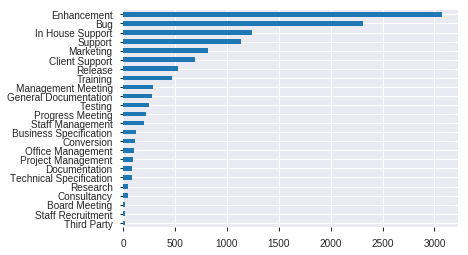

In [0]:
tasks['SubCategory'].value_counts().sort_values().plot.barh();

### Days to complete a task

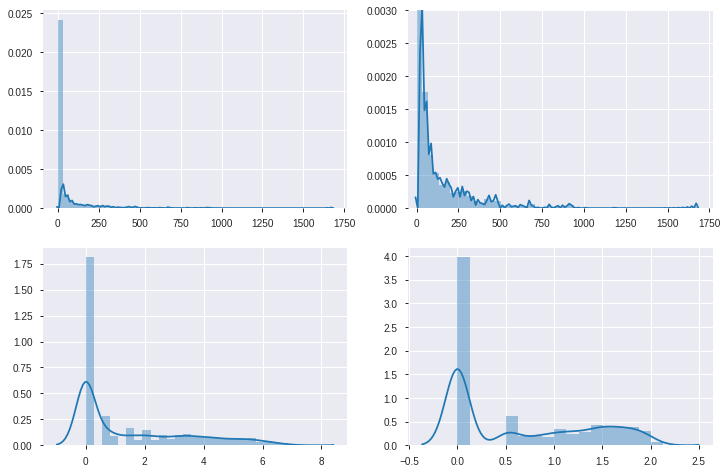

In [0]:
# how many days to complete a task
# it seems to be highly correlated to target feature
taskdays = (pd.to_datetime(dates['CompletedOn'], format='%d-%b-%y') - 
            pd.to_datetime(dates['StartedOn'], format='%d-%b-%y')).dt.days.abs()
s = taskdays.dropna()
plt.figure(figsize=(12,8))
plt.subplot(221)
sns.distplot(s)

# zoom in the distribution
plt.subplot(222)
sns.distplot(s)
plt.xlim(-50.500)
plt.ylim(0,0.003);

plt.subplot(223)
sns.distplot(np.log1p(s))
plt.subplot(224);
sns.distplot(np.log1p(np.log1p(s)));

### Hours & Status Code

In [0]:
# status: the data could be used to estimate "HoursActual" error
tasks['StatusCode'].value_counts()

FINISHED     4950
COMPLETED    4453
CHRONICLE    2323
RELEASED      288
CANCELLED     190
ESTIMATED      86
TEMPLATE        7
AUTHORISE       2
Name: StatusCode, dtype: int64

In [0]:
alldata = tasks.merge(right=dates[-dates.duplicated()], on='TaskNumber', how='inner')
alldata[['StatusCode', 'HoursEstimate', 'HoursActual']].groupby('StatusCode').sum()

HoursEstimate  HoursActual
StatusCode                            
AUTHORISE           11.00        14.50
CANCELLED         3908.68      2567.54
CHRONICLE        44385.73     74682.47
COMPLETED        21996.09     30595.52
ESTIMATED         1663.80       826.30
FINISHED         51558.10     51801.67
RELEASED          1325.97      1483.58
TEMPLATE            10.50        73.50

In [0]:
# how many tasks does a project breakdown have
# this might reflect breakdown complexity
tasknumber = (alldata[['ProjectBreakdownCode', 'TaskNumber']]
              .groupby('ProjectBreakdownCode').nunique())
tasknumber = tasknumber['TaskNumber'].reset_index()
tasknumber.head(3)

ProjectBreakdownCode  TaskNumber
0                 PBC1          12
1                PBC10          60
2                PBC11         370

In [0]:
hoursbreakdown = (alldata[['ProjectBreakdownCode', 'HoursActual']]
                  .groupby('ProjectBreakdownCode').sum())
hoursbreakdown.head(3)

HoursActual
ProjectBreakdownCode             
PBC1                        34.68
PBC10                      195.36
PBC11                     7334.38

In [0]:
hoursbreakdown = hoursbreakdown.merge(right=tasknumber,
                                      on='ProjectBreakdownCode',
                                      how='left')
hoursbreakdown['hourspertask'] = hoursbreakdown['HoursActual'] / hoursbreakdown['TaskNumber']
hoursbreakdown.head()

ProjectBreakdownCode  HoursActual  TaskNumber  hourspertask
0                 PBC1        34.68          12      2.890000
1                PBC10       195.36          60      3.256000
2                PBC11      7334.38         370     19.822649
3                PBC12        29.00           9      3.222222
4                PBC13      3871.53         546      7.090714

(0, 100)

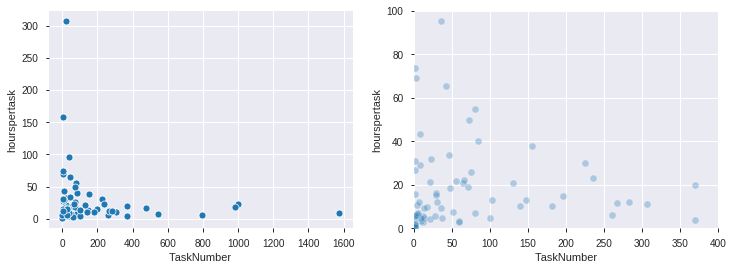

In [0]:
# there is no linear relationship
# hence task number per breakdown will not be used as a feature 
plt.figure(figsize=(12,4))
plt.subplot(121)
sns.scatterplot(x='TaskNumber', y='hourspertask', data=hoursbreakdown)
plt.subplot(122)
sns.scatterplot(x='TaskNumber', y='hourspertask', data=hoursbreakdown,
                alpha=0.3)
plt.xlim(0,400)
plt.ylim(0,100)

### Hours Per Breakdown

In [0]:
hoursproject = (alldata[['ProjectCode', 'HoursActual']]
                  .groupby('ProjectCode').sum())
hoursproject.head(3)

HoursActual
ProjectCode             
PC1               884.72
PC10             1679.02
PC11             2501.71

In [0]:
# how many breakdowns does a project have
# this might reflect project complexity
breakdown = (alldata[['ProjectCode', 'ProjectBreakdownCode']]
             .groupby('ProjectCode').nunique())
breakdown = (breakdown.drop('ProjectCode', axis=1)
             .reset_index())
breakdown.sample(2)

ProjectCode  ProjectBreakdownCode
8         PC17                     8
10        PC19                     8

In [0]:
breakdown = (breakdown.merge(right=hoursproject, on='ProjectCode',
                             how='left'))
breakdown['hoursperbreakdown'] = breakdown['HoursActual'] / breakdown['ProjectBreakdownCode']
breakdown.head()

ProjectCode  ProjectBreakdownCode  HoursActual  hoursperbreakdown
0         PC1                     1       884.72         884.720000
1        PC10                     2      1679.02         839.510000
2        PC11                     8      2501.71         312.713750
3        PC12                     1      1218.68        1218.680000
4        PC13                     3      2307.97         769.323333

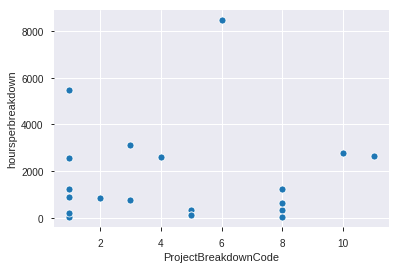

In [0]:
# doesn't seem linear correlated
# may be should remove outliners
sns.scatterplot(x='ProjectBreakdownCode',
                y='hoursperbreakdown',
                data=breakdown);

### Developer performance
Colab widgets https://colab.research.google.com/notebooks/widgets.ipynb#scrollTo=P6xc9QVFSlrw  

In [0]:
# Developer performance
performance = (alldata[['DeveloperID', 'DeveloperPerformance']]
               .groupby('DeveloperID').mean()
               .sort_values('DeveloperPerformance', ascending=False))

# from colab import widgets
grid = widgets.Grid(1,2)
with grid.output_to(0,0):
  print(performance.head())
with grid.output_to(0,1):
  print(performance.tail())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

             DeveloperPerformance
DeveloperID                      
35                      42.000000
33                      41.250000
23                      33.800000
64                      14.000000
54                      11.140244


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

             DeveloperPerformance
DeveloperID                      
50                      -0.816667
26                      -1.234517
2                      -12.129839
45                     -17.172414
53                     -20.354101


<IPython.core.display.Javascript object>

In [0]:
labels = [i for i in range(1,11)] # 1 to 10
performancelevel = pd.cut(performance['DeveloperPerformance'], 
                          bins=10, retbins=False, labels=labels)
performancelevel = (performancelevel
                    .reset_index()
                    .rename(columns={'DeveloperPerformance':'performancelevel'}))
# from colab import widgets
grid = widgets.Grid(1,2)
with grid.output_to(0,0):
  print(performancelevel.head())
with grid.output_to(0,1):
  print(performancelevel.tail())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   DeveloperID performancelevel
0           35               10
1           33               10
2           23                9
3           64                6
4           54                6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

    DeveloperID performancelevel
17           50                4
18           26                4
19            2                2
20           45                1
21           53                1


<IPython.core.display.Javascript object>

# Data Split

In [0]:
# there are duplicate TaskNumbers in both datasets
url_tasks = "https://raw.githubusercontent.com/Derek-Jones/SiP_dataset/master/Sip-task-info.csv"
url_dates = "https://raw.githubusercontent.com/Derek-Jones/SiP_dataset/master/est-act-dates.csv"
tasks  = pd.read_csv(url_tasks, encoding='iso-8859-1')
dates  = pd.read_csv(url_dates, encoding='iso-8859-1')
print(tasks.shape, len(tasks['TaskNumber'].unique()))
print(dates.shape, len(tasks['TaskNumber'].unique()))
set(tasks['TaskNumber']).difference(set(dates['TaskNumber']))

(12299, 17) 10266
(12299, 4) 10266


set()

In [0]:
# there are some tasks have multiple rows
print(tasks[-tasks.duplicated()].shape)
print(dates[-dates.duplicated()].shape)

# merge two datasets
alldata = tasks.merge(right=dates[-dates.duplicated()], on='TaskNumber', how='inner')
print(alldata.shape)

(12299, 17)
(10266, 4)
(12299, 20)


In [0]:
# split train and test data
trainval, test = train_test_split(alldata, test_size=0.1)
print(trainval.shape, test.shape)
assert alldata.shape[0]==trainval.shape[0]+test.shape[0]

(11069, 20) (1230, 20)


In [0]:
target = 'HoursActual'
X_trainval = trainval.drop(target, axis=1)
y_trainval = trainval[target]
y_trainval_log = np.log1p(y_trainval)
X_test = test.drop(target, axis=1)
y_test = test[target]
y_test_log = np.log1p(y_test)

### check data split distribution

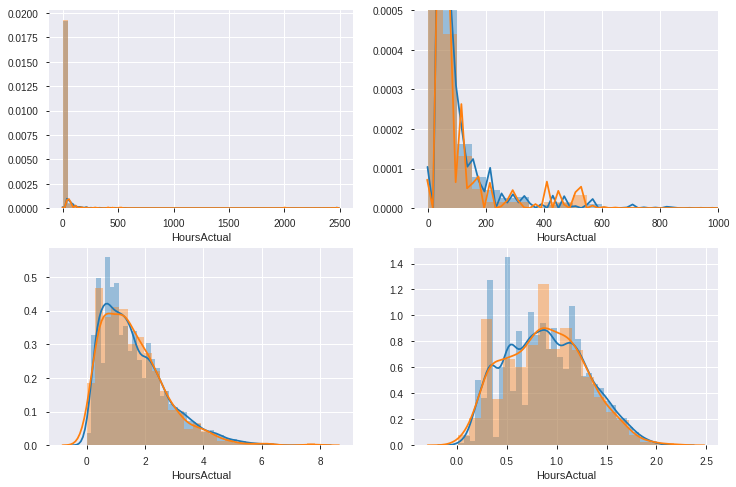

In [0]:
# target value distribution
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
sns.distplot(y_trainval)
sns.distplot(y_test)

# zoom in target feature distribution
# it has a very long tail
plt.subplot(2,2,2)
sns.distplot(y_trainval)
sns.distplot(y_test)
plt.xlim(-50,1000)
plt.ylim(0,0.0005)

plt.subplot(2,2,3)
sns.distplot(y_trainval_log)
sns.distplot(y_test_log)

# not sure whether this would give better prediction
plt.subplot(2,2,4)
y_trainval_log2 = np.log1p(y_trainval_log)
y_test_log2 = np.log1p(y_test_log)
sns.distplot(y_trainval_log2)
sns.distplot(y_test_log2);

# Baseline prediction

In [0]:
y_pred_test_log = [y_trainval_log.median()] * len(y_test)
y_pred_test_log2 = [y_trainval_log2.median()] * len(y_test)
print('baseline prediction:', y_pred_test_log[0])
print('root mean sqaured log error:', rmse(y_test_log, y_pred_test_log), 
                                      rmsle(y_test, np.expm1(y_pred_test_log)))
print('baseline prediction 2:', y_pred_test_log2[0])
print('root mean sqaured log error:', rmse(y_test_log, np.expm1(y_pred_test_log2)), 
                                      rmsle(y_test, np.expm1(np.expm1(y_pred_test_log2))))

baseline prediction: 1.3862943611198906
root mean sqaured log error: 1.070888254224976 1.070888254224976
baseline prediction 2: 0.8697416861919438
root mean sqaured log error: 1.070888254224976 1.070888254224976


# Data wrangling

In [0]:
trainval.columns.to_list()

['TaskNumber',
 'Summary',
 'Priority',
 'RaisedByID',
 'AssignedToID',
 'AuthorisedByID',
 'StatusCode',
 'ProjectCode',
 'ProjectBreakdownCode',
 'Category',
 'SubCategory',
 'HoursEstimate',
 'DeveloperID',
 'DeveloperHoursActual',
 'TaskPerformance',
 'DeveloperPerformance',
 'EstimateOn',
 'StartedOn',
 'CompletedOn']

Data wrangling examples https://drive.google.com/file/d/135stO2VqkfsrWrA-3y1YkPaCUTLRUMr4/view?usp=sharing

In [0]:
def wrangler(X):
## data type conversion  
  X['EstimateOn'] = pd.to_datetime(X['EstimateOn'], format='%d-%b-%y')
  X['StartedOn'] = pd.to_datetime(X['StartedOn'], format='%d-%b-%y')
  X['CompletedOn'] = pd.to_datetime(X['CompletedOn'], format='%d-%b-%y')

## feature engineering
  X['hoursestimatelog'] = np.log1p(X['HoursEstimate'])
  X['daysactual'] = (X['CompletedOn']-X['StartedOn']).dt.days.abs()
  X['estimateonsameday'] = X['EstimateOn']==X['StartedOn']
  ## pandas.DataFrame.merge() behaves awkwardly in a function
  ## so I have to do it in this way
  tmp = (X[['ProjectCode']]
         .merge(right=breakdown, on='ProjectCode', how='left'))
  X['breakdown'] = tmp['ProjectBreakdownCode']
  tmp = (X[['DeveloperID']].merge(right=performancelevel,
                                  on='DeveloperID', how='left'))
  X['performancelevel'] = tmp['performancelevel'].astype(int)

## missing values
  X.replace([np.inf, -np.inf, pd.NaT], np.nan, inplace=True)
  
## convert datasets  
dfs = [trainval, test]
for d in dfs:
  wrangler(d)  

In [0]:
# check features changed
(trainval[['EstimateOn', 'StartedOn', 'CompletedOn', 
           'hoursestimatelog',
           'daysactual', 'estimateonsameday',
           'breakdown', 'performancelevel'
         ]].sample(3))

EstimateOn            StartedOn  ... breakdown  performancelevel
10193 2011-11-05  2011-11-05 00:00:00  ...      11.0               4.0
2934  2006-08-04  2006-08-04 00:00:00  ...       6.0               2.0
9902  2011-06-17  2011-06-17 00:00:00  ...       8.0               4.0

[3 rows x 8 columns]

In [0]:
# check NaTs have been replaced by NaN
print(pd.NaT, np.datetime64('NaT'))
trainval[trainval['CompletedOn'].isna()][['CompletedOn']].sample(2)

NaT NaT


CompletedOn
6090         NaN
6929         NaN

In [0]:
trainval.columns.to_list()

['TaskNumber',
 'Summary',
 'Priority',
 'RaisedByID',
 'AssignedToID',
 'AuthorisedByID',
 'StatusCode',
 'ProjectCode',
 'ProjectBreakdownCode',
 'Category',
 'SubCategory',
 'HoursEstimate',
 'HoursActual',
 'DeveloperID',
 'DeveloperHoursActual',
 'TaskPerformance',
 'DeveloperPerformance',
 'EstimateOn',
 'StartedOn',
 'CompletedOn',
 'hoursestimatelog',
 'daysactual',
 'estimateonsameday',
 'breakdown',
 'performancelevel']

In [0]:
features = trainval.columns.to_list()
target = 'HoursActual'
# remove the following features
fs = [ target,
      'TaskNumber', # Drop because our goal is to predict sales for unknown stores
      'Summary', # test column
      'RaisedByID', 'AssignedToID', 'AuthorisedByID', 'DeveloperID',
      'StatusCode', # this is real-time information
      'ProjectCode', 'ProjectBreakdownCode',
      'DeveloperHoursActual', 'TaskPerformance', 'DeveloperPerformance', # highly correlated with 'HoursActual'
      'EstimateOn', 'StartedOn', 'CompletedOn', # independent on dates
      'daysactual', 'estimateonsameday',  
#       'hoursestimatelog',
      'HoursEstimate',
     ]
for f in fs:
  features.remove(f)
print(len(features), features)

# X_train = X_train[features]
# X_val = X_val[features]
X_trainval = trainval[features]
y_trainval = trainval[target]
y_trainval_log = np.log1p(y_trainval)
X_test = test[features]
y_test = test[target]
y_test_log = np.log1p(y_test)
print(len(features), 
#       X_train.shape[1], X_val.shape[1], 
      X_test.shape[1], X_trainval.shape[1])

6 ['Priority', 'Category', 'SubCategory', 'hoursestimatelog', 'breakdown', 'performancelevel']
6 6 6


# Model comparison
examples https://colab.research.google.com/drive/1mVzsoMY7v4NLYnSPiwx9oozOP8yDVVoI  

In [0]:
numeric_features = X_trainval[features].select_dtypes(include=np.number).columns.to_list()
categorical_features = X_trainval[features].select_dtypes(exclude=np.number).columns.to_list()
print((len(numeric_features), len(categorical_features)))

# select low cardinality features for one-hot encoding
# select high cardinality features for ordinal encoding
highcardi_features, lowcardi_features = [], []
for col in X_trainval[categorical_features]:
  if len(X_trainval[col].value_counts()) >= 10:
    highcardi_features.append(col)
  elif len(X_trainval[col].value_counts()) >= 2:
    lowcardi_features.append(col)  
    
print((len(numeric_features), len(highcardi_features), len(lowcardi_features)))
print('numeric features:', numeric_features)
print('high cardinality features:', highcardi_features)
print('low cardinality features:', lowcardi_features)

(4, 2)
(4, 1, 1)
numeric features: ['Priority', 'hoursestimatelog', 'breakdown', 'performancelevel']
high cardinality features: ['SubCategory']
low cardinality features: ['Category']


In [0]:
###############################################
# Pipeline preprocessor
###############################################
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', ce.OneHotEncoder(drop_invariant=True, use_cat_names=True))]) 
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', ce.OrdinalEncoder())])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('one', onehot_transformer, categorical_features)
#         ('one', onehot_transformer, lowcardi_features), # categorical_features
#         ('ord', ordinal_transformer, highcardi_features), # categorical_features
    ])
random_state = 5
n_jobs = -1

examples https://colab.research.google.com/drive/1FXiTGgH8-85_eH-crw_WO1hbs24Lb8Ge

In [0]:
###############################################
# Compare models
###############################################
regressors = [
    ('kn', KNeighborsRegressor(n_jobs=n_jobs)),
#     ('svc', SVC(kernel="rbf", C=0.025, probability=True)),
#     ('nusvc', NuSVC(probability=True)),
#     ('lr', LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=n_jobs)),
    ('dt', DecisionTreeRegressor(random_state=random_state)),
    ('rf', RandomForestRegressor(random_state=random_state, n_jobs=n_jobs)),    
    ('et', ExtraTreesRegressor(random_state=random_state, n_jobs=n_jobs)),
    ('ada', AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), random_state=random_state)),
    ('gb', GradientBoostingRegressor(random_state=random_state)),
    ]
predictions = []
for regressor in regressors:
  pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              regressor,
                            ])      
  pipeline.fit(X_trainval, y_trainval_log)   
  pred_test = pipeline.predict(X_test)
  predictions.append([list(pipeline.named_steps.keys())[1], pred_test])
  print(regressor)
  # print("R^2 score: %.3f" % pipeline['rf'].score(X_val, np.log1p(y_val)))
#   print("OOB score: %.3f" % pipeline['rf'].oob_score_)
  print("RMSE score: %.3f" % rmse(y_test_log, pred_test))
  print("RMSLE score: %.3f" % rmsle(y_test, np.expm1(pred_test)))
  print()

('kn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                    weights='uniform'))
RMSE score: 0.731
RMSLE score: 0.731

('dt', DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=5, splitter='best'))
RMSE score: 0.736
RMSLE score: 0.736

('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
             

### Without HoursEstimate

```
# without HoursEstimate
('kn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                    weights='uniform'))
RMSE score: 1.140
RMSLE score: 1.140

('dt', DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=5, splitter='best'))
RMSE score: 1.017
RMSLE score: 1.017

('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=5, verbose=0,
                      warm_start=False))
RMSE score: 1.016
RMSLE score: 1.016

('et', ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                    oob_score=False, random_state=5, verbose=0,
                    warm_start=False))
RMSE score: 1.016
RMSLE score: 1.016

('ada', AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=None,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=1.0, loss='linear', n_estimators=50,
                  random_state=5))
RMSE score: 1.122
RMSLE score: 1.122

('gb', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=5,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False))
RMSE score: 1.009
RMSLE score: 1.009
```

### hoursestimatelog

```
# hoursestimatedlog
('kn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                    weights='uniform'))
RMSE score: 0.721
RMSLE score: 0.721

('dt', DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=5, splitter='best'))
RMSE score: 0.768
RMSLE score: 0.768

('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=5, verbose=0,
                      warm_start=False))
RMSE score: 0.721
RMSLE score: 0.721

('et', ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                    oob_score=False, random_state=5, verbose=0,
                    warm_start=False))
RMSE score: 0.732
RMSLE score: 0.732

('ada', AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=None,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=1.0, loss='linear', n_estimators=50,
                  random_state=5))
RMSE score: 0.777
RMSLE score: 0.777

('gb', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=5,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False))
RMSE score: 0.657
RMSLE score: 0.657
```

### HoursEstimate

```
# HoursEstimate
('kn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                    weights='uniform'))
RMSE score: 0.728
RMSLE score: 0.728

('dt', DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=5, splitter='best'))
RMSE score: 0.729
RMSLE score: 0.729

('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=5, verbose=0,
                      warm_start=False))
RMSE score: 0.683
RMSLE score: 0.683

('et', ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                    oob_score=False, random_state=5, verbose=0,
                    warm_start=False))
RMSE score: 0.700
RMSLE score: 0.700

('ada', AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=None,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=1.0, loss='linear', n_estimators=50,
                  random_state=5))
RMSE score: 0.728
RMSLE score: 0.728

('gb', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=5,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False))
RMSE score: 0.682
RMSLE score: 0.682
```

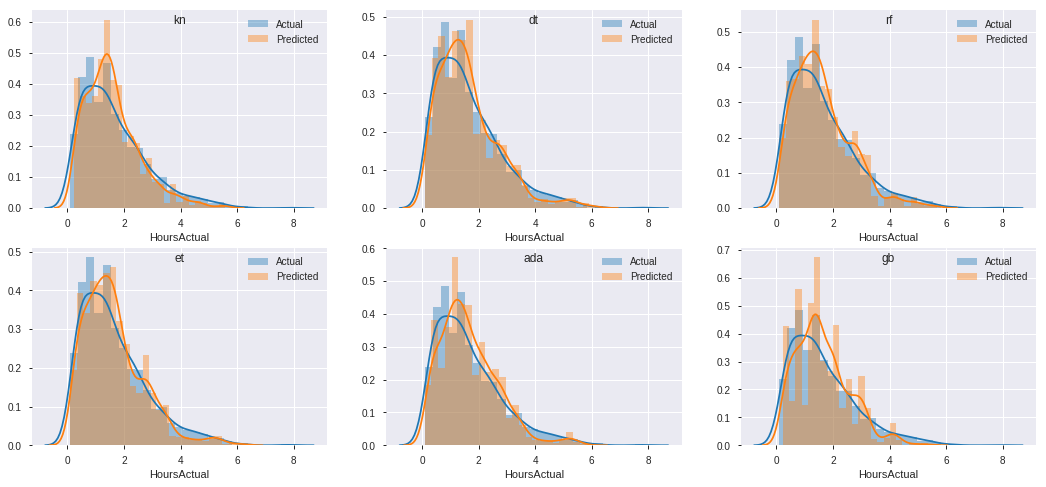

In [0]:
# prediction vs. test data
plt.figure(figsize=(18,8))
for i,p in enumerate(predictions):
  plt.subplot(2,3,i+1)
  sns.distplot(y_test_log, label='Actual')
  sns.distplot(p[1], label='Predicted')
  plt.title(p[0], y=0.9)
  plt.legend()

### XGBoost
Sci-kit Learn API https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn    
DataCamp - Using XGBoost in Python https://www.datacamp.com/community/tutorials/xgboost-in-python  
xgboost generates root-only trees https://github.com/dmlc/xgboost/issues/8  
Incorrect overly simple model is returned #9 https://github.com/dask/dask-xgboost/issues/9  

In [0]:
%%time
###############################################
# XGBoost
###############################################
eval_set = []
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('xgb', XGBRegressor(max_depth=100,
                                                learning_rate=0.001,
                                                n_estimators=10, 
                                                verbosity=3, # debug mode
#                                                 objective ='reg:linear', 
                                                booster='gbtree',
                                                num_boost_round=100,
                                                random_state=random_state,
                                                n_jobs=-1,
                                                scale_pos_weight=1,
                                                eval_set=eval_set, 
                                                eval_metric='rmse',
                                                early_stopping_rounds=10,
                            )),
                    ])
eval_set = [(pipeline['preprocessor'].fit_transform(X_trainval), y_trainval_log),
            (pipeline['preprocessor'].fit_transform(X_test), y_test_log),
           ]
pipeline.fit(X_trainval, y_trainval)   
pred_trainval = pipeline.predict(X_trainval)
print('Validation Error', rmse(y_trainval_log, pred_trainval))
pred_test = pipeline.predict(X_test)
print('Test Error', rmse(y_test_log, pred_test))

[14:16:56] ======== Monitor: Learner ========
[14:16:56] GetGradient: 0.00638635s, 10 calls @ 638us
[14:16:56] PredictRaw: 0.00289699s, 10 calls @ 289us
[14:16:56] UpdateOneIter: 0.854777s, 10 calls @ 85477us
[14:16:56] ======== Monitor: GBTree ========
[14:16:56] BoostNewTrees: 0.804821s, 10 calls @ 80482us
[14:16:56] CommitModel: 0.0405588s, 10 calls @ 4055us
[14:16:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:16:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1064 extra nodes, 0 pruned nodes, max_depth=29
[14:16:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1064 extra nodes, 0 pruned nodes, max_depth=29
[14:16:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1064 extra nodes, 0 pruned nodes, max_depth=29
[14:16:56] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1064 extra nodes, 0 pruned n

In [0]:
# Transformed features
tfs = pipeline['preprocessor'].named_transformers_
features_transformed = (numeric_features +
#                        highcardi_features +
                        tfs['one']['onehot'].get_feature_names())
print('Total features after transformation:', len(features_transformed))

Total features after transformation: 30


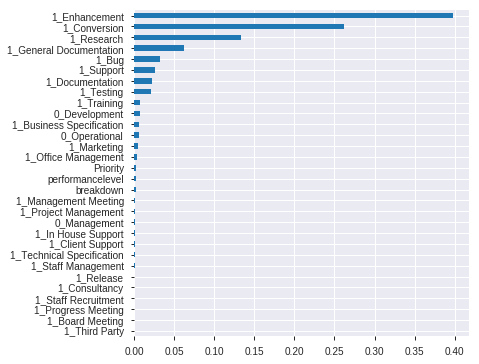

In [0]:
plt.figure(figsize=(6,6))
(pd.Series(pipeline['xgb']
           .feature_importances_, features_transformed)
           .sort_values().plot.barh());

### XGBoost with RandomizedSearchCV

In [0]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('xgb', XGBRegressor(random_state=5)),
                          ])
param_distributions = {
    'xgb__n_estimators': (100, 1500), 
    'xgb__max_depth': (1, 30)
}
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_squared_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)
# groups = trainval['ProjectCode']
search.fit(X_trainval, y_trainval, 
#            groups=groups,
          );

[14:17:15] ======== Monitor: Learner ========
[14:17:15] GetGradient: 0.00671808s, 10 calls @ 671us
[14:17:15] PredictRaw: 0.00297184s, 10 calls @ 297us
[14:17:15] UpdateOneIter: 0.876261s, 10 calls @ 87626us
[14:17:15] ======== Monitor: GBTree ========
[14:17:15] BoostNewTrees: 0.825471s, 10 calls @ 82547us
[14:17:15] CommitModel: 0.0409867s, 10 calls @ 4098us
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:   15.6s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   32.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   32.5s finished


[14:17:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
list(pipeline.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocessor',
 'xgb',
 'preprocessor__n_jobs',
 'preprocessor__remainder',
 'preprocessor__sparse_threshold',
 'preprocessor__transformer_weights',
 'preprocessor__transformers',
 'preprocessor__verbose',
 'preprocessor__num',
 'preprocessor__one',
 'preprocessor__num__memory',
 'preprocessor__num__steps',
 'preprocessor__num__verbose',
 'preprocessor__num__imputer',
 'preprocessor__num__scaler',
 'preprocessor__num__imputer__add_indicator',
 'preprocessor__num__imputer__copy',
 'preprocessor__num__imputer__fill_value',
 'preprocessor__num__imputer__missing_values',
 'preprocessor__num__imputer__strategy',
 'preprocessor__num__imputer__verbose',
 'preprocessor__num__scaler__copy',
 'preprocessor__num__scaler__with_mean',
 'preprocessor__num__scaler__with_std',
 'preprocessor__one__memory',
 'preprocessor__one__steps',
 'preprocessor__one__verbose',
 'preprocessor__one__imputer',
 'preprocessor__one__onehot',
 'preprocessor__one__imputer__add_indicator',
 'preprocessor__one__imputer__copy',
 'preprocessor__one__imputer__fill_value',
 'preprocessor__one__imputer__missing_values',
 'preprocessor__one__imputer__strategy',
 'preprocessor__one__imputer__verbose',
 'preprocessor__one__onehot__cols',
 'preprocessor__one__onehot__drop_invariant',
 'preprocessor__one__onehot__handle_missing',
 'preprocessor__one__onehot__handle_unknown',
 'preprocessor__one__onehot__return_df',
 'preprocessor__one__onehot__use_cat_names',
 'preprocessor__one__onehot__verbose',
 'xgb__base_score',
 'xgb__booster',
 'xgb__colsample_bylevel',
 'xgb__colsample_bynode',
 'xgb__colsample_bytree',
 'xgb__gamma',
 'xgb__importance_type',
 'xgb__learning_rate',
 'xgb__max_delta_step',
 'xgb__max_depth',
 'xgb__min_child_weight',
 'xgb__missing',
 'xgb__n_estimators',
 'xgb__n_jobs',
 'xgb__nthread',
 'xgb__objective',
 'xgb__random_state',
 'xgb__reg_alpha',
 'xgb__reg_lambda',
 'xgb__scale_pos_weight',
 'xgb__seed',
 'xgb__silent',
 'xgb__subsample',
 'xgb__verbosity']

In [0]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation RMSLE', np.sqrt(-search.best_score_))
(pd.DataFrame(search.cv_results_)
 .sort_values(by='rank_test_score')
 .drop('params',axis=1).head(3))

Best hyperparameters {'gb__n_estimators': 10, 'gb__max_depth': 10, 'gb__learning_rate': 0.1}
Cross-validation RMSLE 1.0589504064736386


mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
40       0.331642      0.000853  ...         -1.034668         0.002795
23       2.510992      0.053648  ...         -1.037894         0.003034
41       0.853411      0.015092  ...         -0.971834         0.003358

[3 rows x 16 columns]

### Gridient Boosting

In [0]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('gb', GradientBoostingRegressor(random_state=random_state,)),
                          ])  
list(pipeline.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocessor',
 'gb',
 'preprocessor__n_jobs',
 'preprocessor__remainder',
 'preprocessor__sparse_threshold',
 'preprocessor__transformer_weights',
 'preprocessor__transformers',
 'preprocessor__verbose',
 'preprocessor__num',
 'preprocessor__one',
 'preprocessor__num__memory',
 'preprocessor__num__steps',
 'preprocessor__num__verbose',
 'preprocessor__num__imputer',
 'preprocessor__num__scaler',
 'preprocessor__num__imputer__add_indicator',
 'preprocessor__num__imputer__copy',
 'preprocessor__num__imputer__fill_value',
 'preprocessor__num__imputer__missing_values',
 'preprocessor__num__imputer__strategy',
 'preprocessor__num__imputer__verbose',
 'preprocessor__num__scaler__copy',
 'preprocessor__num__scaler__with_mean',
 'preprocessor__num__scaler__with_std',
 'preprocessor__one__memory',
 'preprocessor__one__steps',
 'preprocessor__one__verbose',
 'preprocessor__one__imputer',
 'preprocessor__one__onehot',
 'preprocessor__one__imputer__add_indicator',
 'preprocessor__one__imputer__copy',
 'preprocessor__one__imputer__fill_value',
 'preprocessor__one__imputer__missing_values',
 'preprocessor__one__imputer__strategy',
 'preprocessor__one__imputer__verbose',
 'preprocessor__one__onehot__cols',
 'preprocessor__one__onehot__drop_invariant',
 'preprocessor__one__onehot__handle_missing',
 'preprocessor__one__onehot__handle_unknown',
 'preprocessor__one__onehot__return_df',
 'preprocessor__one__onehot__use_cat_names',
 'preprocessor__one__onehot__verbose',
 'gb__alpha',
 'gb__criterion',
 'gb__init',
 'gb__learning_rate',
 'gb__loss',
 'gb__max_depth',
 'gb__max_features',
 'gb__max_leaf_nodes',
 'gb__min_impurity_decrease',
 'gb__min_impurity_split',
 'gb__min_samples_leaf',
 'gb__min_samples_split',
 'gb__min_weight_fraction_leaf',
 'gb__n_estimators',
 'gb__n_iter_no_change',
 'gb__presort',
 'gb__random_state',
 'gb__subsample',
 'gb__tol',
 'gb__validation_fraction',
 'gb__verbose',
 'gb__warm_start']

In [0]:
%%time
param_distributions = {
    'gb__learning_rate':(0.001, 0.01, 0.1),
    'gb__max_depth':(10, 20, 30, 40, 50),
    'gb__n_estimators':(10, 30, 50, 100),     
}
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=1000, 
    cv=2, 
    scoring='neg_mean_squared_error', 
    verbose=10, 
    return_train_score=True, 
    random_state=random_state,
    n_jobs=-1
)
search.fit(X_trainval, y_trainval_log) 

Fitting 2 folds for each of 60 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.3min finished


CPU times: user 1.88 s, sys: 165 ms, total: 2.04 s
Wall time: 2min 17s


In [0]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation RMSLE', np.sqrt(-search.best_score_))
(pd.DataFrame(search.cv_results_)
 .sort_values(by='rank_test_score')
 .drop('params',axis=1).head(3))

Best hyperparameters {'gb__n_estimators': 10, 'gb__max_depth': 10, 'gb__learning_rate': 0.1}
Cross-validation RMSLE 1.0589504064736386


mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
40       0.331642      0.000853  ...         -1.034668         0.002795
23       2.510992      0.053648  ...         -1.037894         0.003034
41       0.853411      0.015092  ...         -0.971834         0.003358

[3 rows x 16 columns]

In [0]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('gb', GradientBoostingRegressor(n_estimators=28,
                                                            max_depth=8,
                                                            learning_rate=0.1,
                                                            random_state=random_state,
                                                           )),
                          ]) 
pipeline.fit(X_trainval, y_trainval_log)
pred_trainval = pipeline.predict(X_trainval)
print("trainval RMSE score: %.3f" % rmse(y_trainval_log, pred_trainval))
pred_test = pipeline.predict(X_test)
print("test RMSE score: %.3f" % rmse(y_test_log, pred_test))

trainval RMSE score: 1.016
test RMSE score: 1.059


# Model tuning
### Random forests RandomizedSearchCV

In [0]:
###############################################
# Random Forests
###############################################
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('rf', RandomForestRegressor(random_state=random_state, n_jobs=n_jobs)), 
                          ])    
list(pipeline.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocessor',
 'rf',
 'preprocessor__n_jobs',
 'preprocessor__remainder',
 'preprocessor__sparse_threshold',
 'preprocessor__transformer_weights',
 'preprocessor__transformers',
 'preprocessor__verbose',
 'preprocessor__num',
 'preprocessor__one',
 'preprocessor__num__memory',
 'preprocessor__num__steps',
 'preprocessor__num__verbose',
 'preprocessor__num__imputer',
 'preprocessor__num__scaler',
 'preprocessor__num__imputer__add_indicator',
 'preprocessor__num__imputer__copy',
 'preprocessor__num__imputer__fill_value',
 'preprocessor__num__imputer__missing_values',
 'preprocessor__num__imputer__strategy',
 'preprocessor__num__imputer__verbose',
 'preprocessor__num__scaler__copy',
 'preprocessor__num__scaler__with_mean',
 'preprocessor__num__scaler__with_std',
 'preprocessor__one__memory',
 'preprocessor__one__steps',
 'preprocessor__one__verbose',
 'preprocessor__one__imputer',
 'preprocessor__one__onehot',
 'preprocessor__one__imputer__add_indicator',
 'preprocessor__one__imputer__copy',
 'preprocessor__one__imputer__fill_value',
 'preprocessor__one__imputer__missing_values',
 'preprocessor__one__imputer__strategy',
 'preprocessor__one__imputer__verbose',
 'preprocessor__one__onehot__cols',
 'preprocessor__one__onehot__drop_invariant',
 'preprocessor__one__onehot__handle_missing',
 'preprocessor__one__onehot__handle_unknown',
 'preprocessor__one__onehot__return_df',
 'preprocessor__one__onehot__use_cat_names',
 'preprocessor__one__onehot__verbose',
 'rf__bootstrap',
 'rf__criterion',
 'rf__max_depth',
 'rf__max_features',
 'rf__max_leaf_nodes',
 'rf__min_impurity_decrease',
 'rf__min_impurity_split',
 'rf__min_samples_leaf',
 'rf__min_samples_split',
 'rf__min_weight_fraction_leaf',
 'rf__n_estimators',
 'rf__n_jobs',
 'rf__oob_score',
 'rf__random_state',
 'rf__verbose',
 'rf__warm_start']

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

In [0]:
%%time
param_distributions = {
    'rf__max_depth': (10, 20, 30, 40, 50),
    'rf__n_estimators': (100, 500, 1000, 1500, 2000, 3000),     
}
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=1000, 
    cv=2, 
    scoring='neg_mean_squared_error', 
    verbose=10, 
    return_train_score=True, 
    random_state=random_state,
    n_jobs=-1
)
# groups = trainval['ProjectCode']
search.fit(X_trainval, y_trainval_log, 
#            groups=groups,
          ) 
"""
Fitting 2 folds for each of 25 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 13.6min finished
CPU times: user 1min 2s, sys: 745 ms, total: 1min 3s
Wall time: 14min 12s
"""

Fitting 2 folds for each of 30 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  8.1min finished


CPU times: user 26.3 s, sys: 1.29 s, total: 27.5 s
Wall time: 8min 22s


In [0]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation RMSLE', np.sqrt(-search.best_score_))
(pd.DataFrame(search.cv_results_)
 .sort_values(by='rank_test_score')
 .drop('params',axis=1).head(3))

Best hyperparameters {'rf__n_estimators': 2000, 'rf__max_depth': 10}
Cross-validation RMSLE 1.063297575448728


mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
4      14.609841      0.210798  ...         -1.006301         0.026288
5      21.858296      0.346332  ...         -1.006241         0.026261
3      10.944453      0.161513  ...         -1.006230         0.026183

[3 rows x 15 columns]

In [0]:
%%time
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('rf', RandomForestRegressor(
                               n_estimators=search.best_params_['rf__n_estimators'],
                               max_depth=search.best_params_['rf__max_depth'],
                               random_state=random_state, 
                               n_jobs=n_jobs)), 
                          ])    
pipeline.fit(X_trainval, y_trainval_log)
pred_trainval = pipeline.predict(X_trainval)
print("trainval RMSE score: %.3f" % rmse(y_trainval_log, pred_trainval))
# print("R^2 score: %.3f" % pipeline['rf'].score(X_val, np.log1p(y_val)))
#   print("OOB score: %.3f" % pipeline['rf'].oob_score_)

trainval RMSE score: 1.018
CPU times: user 26.8 s, sys: 435 ms, total: 27.3 s
Wall time: 14.6 s


In [0]:
%%time
pred_test = pipeline.predict(X_test)
print("test RMSE score: %.3f" % rmse(y_test_log, pred_test))

test RMSE score: 1.012
CPU times: user 554 ms, sys: 80.8 ms, total: 635 ms
Wall time: 531 ms


Total features after transformation: 30


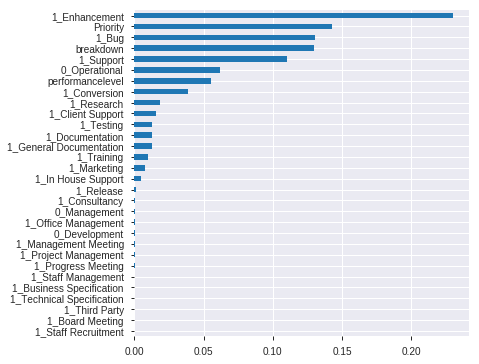

In [0]:
# Transformed features
tfs = pipeline['preprocessor'].named_transformers_
features_transformed = (numeric_features +
#                        highcardi_features +
                        tfs['one']['onehot'].get_feature_names())
print('Total features after transformation:', len(features_transformed))

plt.figure(figsize=(6,6))
(pd.Series(pipeline['rf']
           .feature_importances_, features_transformed)
           .sort_values().plot.barh());

In [0]:
param_distributions = {
    'rf__max_depth': [i for i in range(1,30)],
    'rf__n_estimators': [10, 20, 30]  
}
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=1000, 
    cv=2, 
    scoring='neg_mean_squared_error', 
    verbose=10, 
    return_train_score=True, 
    random_state=random_state,
    n_jobs=-1
)
search.fit(X_trainval, y_trainval_log)

print('Best hyperparameters', search.best_params_)
print('Cross-validation RMSLE', np.sqrt(-search.best_score_))
(pd.DataFrame(search.cv_results_)
 .sort_values(by='rank_test_score')
 .drop('params',axis=1).head(3))

Fitting 2 folds for each of 87 candidates, totalling 174 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

Best hyperparameters {'rf__n_estimators': 30, 'rf__max_depth': 6}
Cross-validation RMSLE 1.054917479287369


mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
17       0.192574      0.000281  ...         -1.070917         0.025291
16       0.187656      0.000527  ...         -1.071246         0.025617
15       0.187742      0.004302  ...         -1.072335         0.024387

[3 rows x 15 columns]

### Random forests manually tuning

In [0]:
%%time
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('rf', RandomForestRegressor(
                               n_estimators=29,
                               max_depth=6,
                               random_state=random_state, 
                               n_jobs=n_jobs)), 
                          ])    
pipeline.fit(X_trainval, y_trainval_log)
pred_trainval = pipeline.predict(X_trainval)
print("trainval RMSE score: %.3f" % rmse(y_trainval_log, pred_trainval))
# print("R^2 score: %.3f" % pipeline['rf'].score(X_val, np.log1p(y_val)))
#   print("OOB score: %.3f" % pipeline['rf'].oob_score_)
pred_test = pipeline.predict(X_test)
print("test RMSE score: %.3f" % rmse(y_test_log, pred_test))

trainval RMSE score: 0.643
test RMSE score: 0.684
CPU times: user 463 ms, sys: 15.1 ms, total: 478 ms
Wall time: 567 ms


Total features after transformation: 31


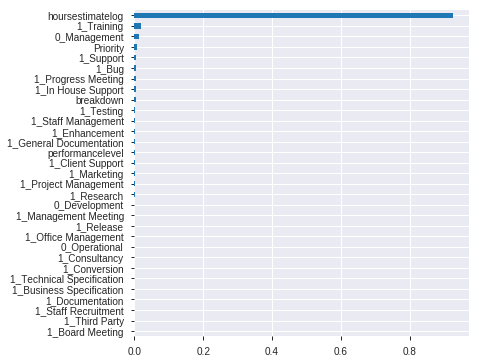

In [0]:
# Transformed features
tfs = pipeline['preprocessor'].named_transformers_
features_transformed = (numeric_features +
#                        highcardi_features +
                        tfs['one']['onehot'].get_feature_names())
print('Total features after transformation:', len(features_transformed))
plt.figure(figsize=(6,6))
(pd.Series(pipeline['rf']
           .feature_importances_, features_transformed)
           .sort_values().plot.barh());

In [0]:
np.log1p(2500)

7.824445930877619

trainval RMSE score: 0.643
test RMSE score: 0.684
RMSE score: 0.647


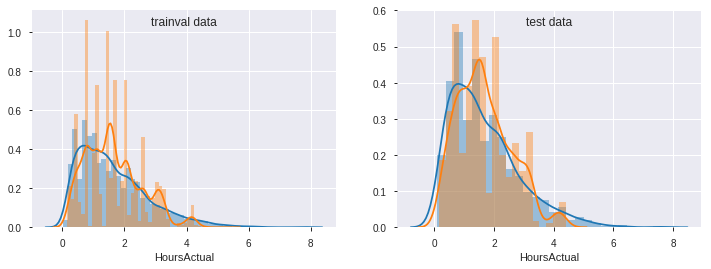

In [355]:
plt.figure(figsize=(12,4))
plt.subplot(121)
sns.distplot(y_trainval_log, label='HoursActual')
sns.distplot(pred_trainval, label='Predicted')
plt.title('trainval data', y=0.9)
plt.subplot(122)
sns.distplot(y_test_log, label='HoursActual')
sns.distplot(pred_test, label='Predicted')
plt.title('test data', y=0.9);


print("trainval RMSE score: %.3f" % rmse(y_trainval_log, pred_trainval))
print("test RMSE score: %.3f" % rmse(y_test_log, pred_test))
print("RMSE score: %.3f" % rmse(list(y_trainval_log)+list(y_test_log), 
                                list(pred_trainval)+list(pred_test)))

HoursEstimate RMSE score: 0.752


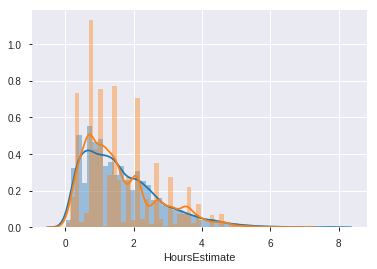

In [0]:
actual_log = np.log1p(alldata['HoursActual'])
estimate_log = np.log1p(alldata['HoursEstimate'])
sns.distplot(actual_log, label='HoursActual')
sns.distplot(estimate_log, label='HoursEstimate')
print("HoursEstimate RMSE score: %.3f" % rmse(estimate_log, actual_log))

(-50, 30)

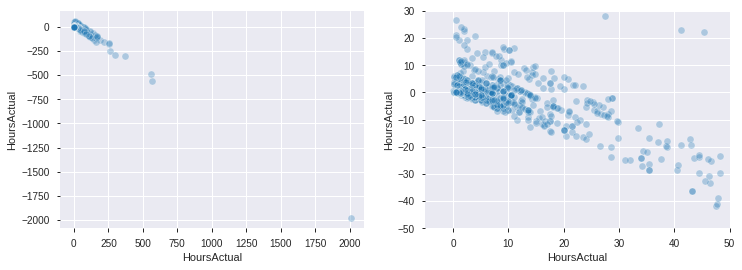

In [0]:
# prediction errors
errors = np.expm1(pred_test) - y_test
plt.figure(figsize=(12,4))
plt.subplot(121)
sns.scatterplot(y_test, errors, alpha=0.3)
plt.subplot(122)
sns.scatterplot(y_test, errors, alpha=0.3)
plt.xlim(-5,50)
plt.ylim(-50,30)

### Remove outliers & Predict without HoursEstimate

In [362]:
np.log1p(200)

5.303304908059076

In [397]:
features = trainval.columns.to_list()
target = 'HoursActual'
# remove the following features
fs = [ target,
      'TaskNumber', # Drop because our goal is to predict sales for unknown stores
      'Summary', # test column
      'RaisedByID', 'AssignedToID', 'AuthorisedByID', 'DeveloperID',
      'StatusCode', # this is real-time information
      'ProjectCode', 'ProjectBreakdownCode',
      'DeveloperHoursActual', 'TaskPerformance', 'DeveloperPerformance', # highly correlated with 'HoursActual'
      'EstimateOn', 'StartedOn', 'CompletedOn', # independent on dates
      'daysactual', 'estimateonsameday',  
      'hoursestimatelog',
#       'HoursEstimate',
     ]

for f in fs:
  features.remove(f)
print(len(features), features)
cutoff = 200
# X_train = X_train[features]
# X_val = X_val[features]
X_trainval = trainval[trainval['HoursActual']<=cutoff][features]
y_trainval = trainval[trainval['HoursActual']<=cutoff][target]
y_trainval_log = np.log1p(y_trainval)
y_trainval_log2 = np.log1p(y_trainval_log)
X_test = test[test['HoursActual']<=cutoff][features]
y_test = test[test['HoursActual']<=cutoff][target]
y_test_log = np.log1p(y_test)
y_test_log2 = np.log1p(y_test_log2)
print(len(features), 
#       X_train.shape[1], X_val.shape[1], 
      X_test.shape[1], X_trainval.shape[1])

6 ['Priority', 'Category', 'SubCategory', 'HoursEstimate', 'breakdown', 'performancelevel']
6 6 6


In [398]:
%%time
numeric_features = X_trainval[features].select_dtypes(include=np.number).columns.to_list()
categorical_features = X_trainval[features].select_dtypes(exclude=np.number).columns.to_list()
print((len(numeric_features), len(categorical_features)))

# select low cardinality features for one-hot encoding
# select high cardinality features for ordinal encoding
highcardi_features, lowcardi_features = [], []
for col in X_trainval[categorical_features]:
  if len(X_trainval[col].value_counts()) >= 10:
    highcardi_features.append(col)
  elif len(X_trainval[col].value_counts()) >= 2:
    lowcardi_features.append(col)  
    
# print((len(numeric_features), len(highcardi_features), len(lowcardi_features)))
# print('numeric features:', numeric_features)
# print('high cardinality features:', highcardi_features)
# print('low cardinality features:', lowcardi_features)

###############################################
# Pipeline preprocessor
###############################################
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', ce.OneHotEncoder(drop_invariant=True, use_cat_names=True))]) 
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', ce.OrdinalEncoder())])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('one', onehot_transformer, categorical_features)
#         ('one', onehot_transformer, lowcardi_features), # categorical_features
#         ('ord', ordinal_transformer, highcardi_features), # categorical_features
    ])
random_state = 5
n_jobs = -1

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('rf', RandomForestRegressor(
                               n_estimators=29,
                               max_depth=10,
                               random_state=random_state, 
                               n_jobs=n_jobs)), 
                          ]) 
pipeline.fit(X_trainval, y_trainval_log2)
pred_trainval = pipeline.predict(X_trainval)
print("trainval RMSE score: %.3f" % rmse(y_trainval_log, np.expm1(pred_trainval)))
pred_test = pipeline.predict(X_test)
print("test RMSE score: %.3f" % rmse(y_test_log, np.expm1(pred_test)))

(4, 2)
trainval RMSE score: 0.562
test RMSE score: 0.633
CPU times: user 639 ms, sys: 28.4 ms, total: 667 ms
Wall time: 697 ms


Total features after transformation: 31


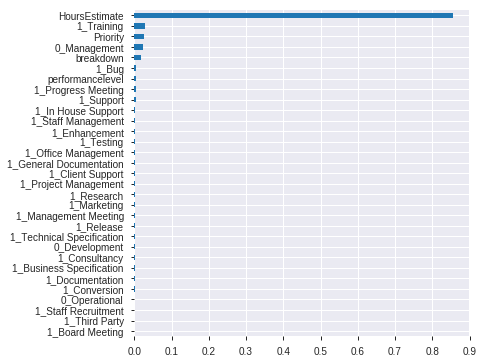

In [399]:
# Transformed features
tfs = pipeline['preprocessor'].named_transformers_
features_transformed = (numeric_features +
#                        highcardi_features +
                        tfs['one']['onehot'].get_feature_names())
print('Total features after transformation:', len(features_transformed))
plt.figure(figsize=(6,6))
(pd.Series(pipeline['rf']
           .feature_importances_, features_transformed)
           .sort_values().plot.barh());

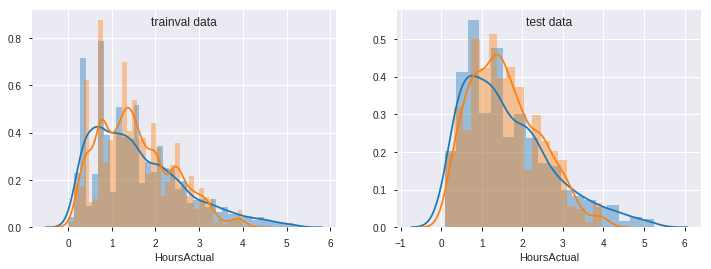

In [400]:
pred_trainval = np.expm1(pred_trainval)
pred_test = np.expm1(pred_test)

plt.figure(figsize=(12,4))
plt.subplot(121)
sns.distplot(y_trainval_log, label='HoursActual')
sns.distplot(pred_trainval, label='Predicted')
plt.title('trainval data', y=0.9)
plt.subplot(122)
sns.distplot(y_test_log, label='HoursActual')
sns.distplot(pred_test, label='Predicted')
plt.title('test data', y=0.9);

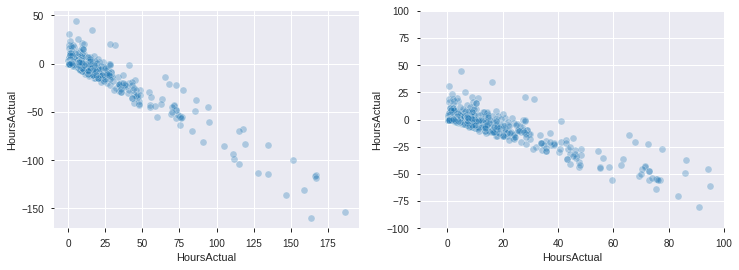

In [401]:
# prediction errors
errors = np.expm1(pred_test) - y_test

plt.figure(figsize=(12,4))
plt.subplot(121)
sns.scatterplot(y_test, errors, alpha=0.3)
plt.subplot(122)
sns.scatterplot(y_test, errors, alpha=0.3)
plt.xlim(-10,100)
plt.ylim(-100,100);